In [4]:
# https://colab.research.google.com/github/fastai/fastbook/blob/master/09_tabular.ipynb#scrollTo=CSTqZVZnKMx1
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator

In [6]:
# Used to get rid of some pandas warnings.
pd.set_option('mode.chained_assignment', None)

In [7]:
# Reading in the taxi zone data and combining the data.
sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

# Convert the geometry shaape to to latitude and longitude
# Tute 2 Applied Data Science Tutorial Materials
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

hour_all = pd.read_parquet('../data/curated/hour_all/')
hour_all['date_time'] = pd.to_datetime(hour_all['date_time'])
hour_all = pd.merge(hour_all, gdf, left_on='pulocationid', right_on='LocationID', how='inner')


In [9]:
# We are not interested in the other taxi zone variables when creating our model.
hour_all = hour_all[['demand', 'rain', 'wind', 'cloud', 'temp', 'date_time', 'Zone']]

In [10]:
# Using the first 10 months for training and validation.
df = hour_all.loc[hour_all['date_time'].dt.month <= 10]
# Using the last 2 months for testing
df_test = hour_all.loc[(hour_all['date_time'].dt.month > 10)]

In [11]:
# Ensuring zone categories are properly encoded.
zones = df['Zone'].unique()
df['Zone'] = df['Zone'].astype('category')
df['Zone'].cat.set_categories(zones, ordered=True, inplace=True)

/tmp/ipykernel_6623/326839856.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Zone'].cat.set_categories(zones, ordered=True, inplace=True)


In [12]:
dep_var = 'demand'
# When transforming our data we chose to add a constant of 2 to avoid infinite values.
# Some nights in outer zones have only 0 or 1 hourly demand
df[dep_var] = np.log(df[dep_var] + 2)

In [13]:
# Adding datepart variables such as weekday, hour, etc
df = add_datepart(df, 'date_time', time = True)

In [14]:
# Splitting data into training and validation data
# First 9 months training, 1 month validation
cond = (df.date_timeMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [15]:
# Splitting continuous and categorical variables
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [16]:
# Splitting training/validation sets
procs = [Categorify]
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [17]:
len(to.train),len(to.valid)

(589535, 69255)

In [18]:
# Extracting Training Data.
xs,y = to.train.xs,to.train.y
# Extracting Validation Data. 
valid_xs,valid_y = to.valid.xs,to.valid.y

In [19]:
# Root mean squared error functions 
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [21]:
# Picking out our desired variables.
xs = xs[['Zone', 'rain', 'wind', 'cloud', 'temp', 'date_timeDayofweek', 'date_timeHour',]]
valid_xs = valid_xs[['Zone', 'rain', 'wind', 'cloud', 'temp', 'date_timeDayofweek', 'date_timeHour',]]

In [22]:
# testing for hyperparameter min samples leaf
for i in [5, 10, 20, 25, 30, 35]:
    m = DecisionTreeRegressor(min_samples_leaf=i)
    m.fit(xs, to.train.y)
    print(m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y))

0.212934 0.305854
0.250293 0.2851
0.274857 0.270487
0.2808 0.269057
0.285997 0.268719
0.289564 0.269008


In [25]:
# sf stands for shape file
sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

# Convert the geometry shaape to to latitude and longitude
# Tute 2 Applied Data Science Tutorial Materials
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

hour_all = pd.read_parquet('../data/curated/hour_all/')
hour_all['date_time'] = pd.to_datetime(hour_all['date_time'])
hour_all = pd.merge(hour_all, gdf, left_on='pulocationid', right_on='LocationID', how='inner')
hour_all = hour_all[['demand', 'rain', 'wind', 'cloud', 'temp', 'date_time','Zone']]

In [26]:
# Now we train our model on the full time from Jan to October, testing on Nov to Dec

zones = hour_all['Zone'].unique()
hour_all['Zone'] = hour_all['Zone'].astype('category')
hour_all['Zone'].cat.set_categories(zones, ordered=True, inplace=True)

dep_var = 'demand'
hour_all[dep_var] = np.log(hour_all[dep_var] + 2)

hour_all = add_datepart(hour_all, 'date_time', time = True)

/tmp/ipykernel_6623/3811235753.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  hour_all['Zone'].cat.set_categories(zones, ordered=True, inplace=True)


In [27]:
# Splitting training and test data
# Train: Jan to Oct
# Test: Nov to Dec
cond = (hour_all.date_timeMonth <= 10)
train_idx = np.where( cond)[0]
test_idx = np.where(~cond)[0]
splits = (list(train_idx),list(test_idx))

In [28]:
# Splitting continuous and categorical vars.
cont,cat = cont_cat_split(hour_all, 1, dep_var=dep_var)

procs = [Categorify]
to_test = TabularPandas(hour_all, procs, cat, cont, y_names=dep_var, splits=splits)

In [29]:
len(to_test.train),len(to_test.valid)

(658790, 133177)

In [31]:
xs,y = to_test.train.xs,to_test.train.y
test_xs,test_y = to_test.valid.xs,to_test.valid.y

# Only selecting our chosen variables.
xs = xs[['Zone', 'rain', 'wind', 'cloud', 'temp', 'date_timeDayofweek', 'date_timeHour']]
test_xs = test_xs[['Zone', 'rain', 'wind', 'cloud', 'temp', 'date_timeDayofweek', 'date_timeHour']]

m = DecisionTreeRegressor(min_samples_leaf=30)
m.fit(xs, y)

m_rmse(m, xs, y), m_rmse(m, test_xs, test_y)

(0.280385, 0.343234)

In [32]:
# Finding the r squared score. 
actual = test_y
predict =  m.predict(test_xs)

corr_matrix = np.corrcoef(actual, predict)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

0.950199827496198


Plotting our predicted hourly demands based on the: the highest demand zones in each borough.

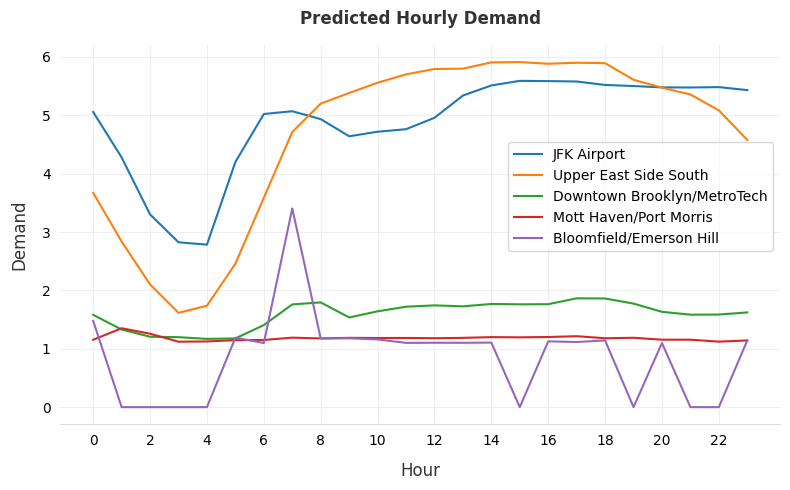

In [33]:
test_xs = test_xs.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
zones = ['JFK Airport', 'Upper East Side South', 'Downtown Brooklyn/MetroTech', 'Mott Haven/Port Morris', 'Bloomfield/Emerson Hill']
for zone in zones:
    cat = to_test.procs.categorify
    # Finding the encoded index of the zone classes
    ind = list(cat.classes['Zone']).index(zone)

    # Finding the instances that coincide with the indexes
    condition = test_xs['Zone'] == ind
    indices = test_xs.index[condition].tolist()
    pred = predict[indices]
    hours = list(test_xs.iloc[indices]['date_timeHour'])

    # Extracting the hourly averages
    hr = [0]* 24
    counts = [0]* 24
    for i in range(len(pred)):
        hr[hours[i]] += pred[i]
        counts[hours[i]] += 1
    
    for i in range(24):
        if counts[i] != 0:
            hr[i] = hr[i]/counts[i]

    x = np.array(range(24))
    y = hr
    ax.plot(x, y, label=zone)


# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE')


x_tick_positions = np.arange(0, 23, 2)
ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))

# Label formatting.
ax.set_xlabel('Hour', labelpad=10, color='#333333', fontsize = 12)
ax.set_ylabel('Demand', labelpad=10, color='#333333', fontsize = 12)
ax.set_title('Predicted Hourly Demand', pad=15,  color='#333333',
             weight='bold')

#  ax.legend(loc='center right')
ax.legend(loc='center right', bbox_to_anchor=(1, 0.6), fancybox=True)
fig.tight_layout()
plt.savefig('../plots/pred_demand.jpg', dpi=400)

Plotting our predicted hourly demand based on weather or not the hourly rain count is > 0.5mm or not. 

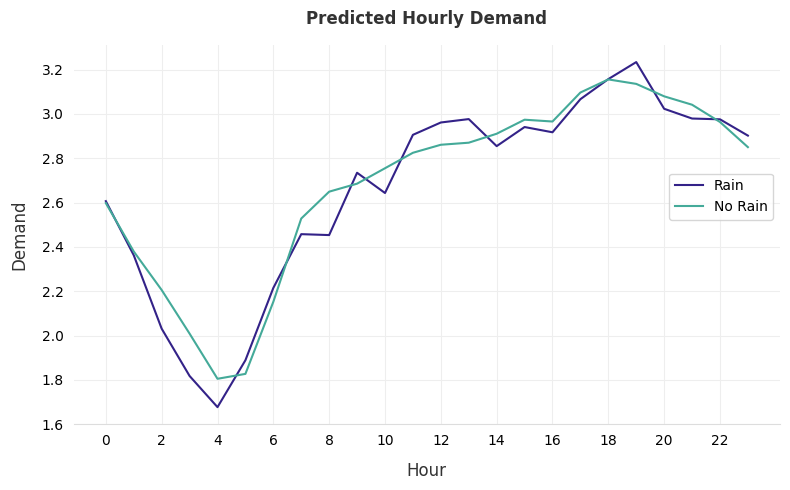

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))

# Finding instances which fit the rain condition
condition = test_xs['rain'] > 0.5
indices = test_xs.index[condition].tolist()
pred = predict[indices]
hours = list(test_xs.iloc[indices]['date_timeHour'])

hr = [0]* 24
counts = [0]* 24
for i in range(len(pred)):
    hr[hours[i]] += pred[i]
    counts[hours[i]] += 1

for i in range(24):
    if counts[i] != 0:
        hr[i] = hr[i]/counts[i]

x = np.array(range(24))
y = hr
# Plotting the predicted hourly demand for rain.
ax.plot(x, y, label="Rain", c = '#332288')


# Finding instances which fit the no rain condition
condition = test_xs['rain'] < 0.5
indices = test_xs.index[condition].tolist()
pred = predict[indices]
hours = list(test_xs.iloc[indices]['date_timeHour'])

hr = [0]* 24
counts = [0]* 24
for i in range(len(pred)):
    hr[hours[i]] += pred[i]
    counts[hours[i]] += 1

for i in range(24):
    if counts[i] != 0:
        hr[i] = hr[i]/counts[i]

x = np.array(range(24))
y = hr
# Plotting the predicted hourly demand for no rain
ax.plot(x, y, label="No Rain", c = '#44AA99')

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE')


x_tick_positions = np.arange(0, 23, 2)
ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))

# Label formatting.
ax.set_xlabel('Hour', labelpad=10, color='#333333', fontsize = 12)
ax.set_ylabel('Demand', labelpad=10, color='#333333', fontsize = 12)
ax.set_title('Predicted Hourly Demand', pad=15,  color='#333333',
             weight='bold')

ax.legend(loc='center right', bbox_to_anchor=(1, 0.6), fancybox=True)

fig.tight_layout()
plt.savefig('../plots/pred_rain_demand.jpg', dpi=400)